# Hyperparameter tuning

In [1]:
# import sys
# sys.path.append("..")
import pickle
# import random
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
# from models.mlp_original import MLPModel
from functools import partial
# from imitation_learning.dataset.frame_dataset_dict import Float115Dataset
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
# import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import random

In [2]:
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
# import numpy as np
# # from os.path import join
# # import pickle
# from torch.utils.data import Dataset
# # import time
# class Float115Dataset(Dataset):

#     def __init__(self, frames, data_dict, transform=None):
#         self.frame_ids = frames
#         self.data_dict = data_dict
#         self.transform = transform
#         self.count = 0
#         self.timer = 0.0
#     def __getitem__(self, idx):
#         frame_id = self.frame_ids[0][idx]
#         obs_with_action = self.data_dict[frame_id]
#         # end = time.perf_counter()
#         obs = obs_with_action[0:115]
#         action = obs_with_action[115]
# #         print("deleting")
#         del(obs_with_action)
#         del(frame_id)
#         # self.count += 1
        
#         # self.timer += end - start
#         # if (self.count + 1) % 129 == 0:
#         #     print(f"Average time to load each file from the disk: {(self.timer/self.count):0.4f}")
#         # print(f"Average time to load each pickle file from the disk: {(end-start):0.4f}")
#         return obs, int(action)

#     def __len__(self):
#         return len(self.frame_ids)

### Creating the dataset

In [4]:
import numpy as np
from os.path import join
import pickle
from torch.utils.data import Dataset
# import time
class Float115DatasetBatched(Dataset):

    def __init__(self, data, path = None, transform=None):
        self.data = data
        self.transform = transform
        self.path = path
        self.count = 0
        self.timer = 0.0
    def __getitem__(self, idx):
        file_path = join(self.path, self.data[idx])
        # start = time.perf_counter()
        try:
            with open(file_path, 'rb') as pkl_file:
                data_dict = pickle.load(pkl_file)
        except ValueError:
            print(f"The file was not found in the directory")
        # end = time.perf_counter()
        obs = data_dict['obs']
        action = data_dict['action']
        del(file_path)
        return obs, action

    def __len__(self):
        return self.data.shape[0]

In [5]:
# def load_data(data_dir=None):
# # Creating Train, Val and Test Dataset
#     with open(data_dir, 'rb') as pkl_file:
#         dict_dataset = pickle.load(pkl_file)
#     dataset = pd.DataFrame(dict_dataset.keys())
#     train, val, test = np.split(dataset.sample(frac=1, random_state=42), [
#                                         int(.6 * len(dataset)), int(.8 * len(dataset))])
#     train, val, test = train.reset_index(drop=True), \
#                                             val.reset_index(drop=True), \
#                                             test.reset_index(drop=True)
    
#     train_dataset, val_dataset, test_dataset = Float115Dataset(train, dict_dataset), \
#                                             Float115Dataset(val, dict_dataset), \
#                                             Float115Dataset(test, dict_dataset)
    
# #     trainset = torchvision.datasets.CIFAR10(
# #         root=data_dir, train=True, download=True, transform=transform)

# #     testset = torchvision.datasets.CIFAR10(
# #         root=data_dir, train=False, download=True, transform=transform)
#     del(dataset)
#     del(train)
#     del(val)
#     del(test)
#     del(pkl_file)
#     del(dict_dataset)
#     return train_dataset, val_dataset, test_dataset

In [6]:
def load_data(data_dir=None, mode=None):    
    if mode == 'train':
        train_data_path = os.path.join(data_dir, 'train')
        val_data_path = os.path.join(data_dir, 'val')
        train, val = np.array(sorted(os.listdir(train_data_path)), dtype='str'),\
                    np.array(sorted(os.listdir(val_data_path)), dtype='str')
        train_dataset, val_dataset = Float115DatasetBatched(train, train_data_path), \
                                        Float115DatasetBatched(val, val_data_path)
        del(train)
        del(val)
        return train_dataset, val_dataset
    elif mode == 'test':
        test_data_path = os.path.join(data_dir, 'test')
        test = np.array(sorted(os.listdir(test_data_path)), dtype='str')
        test_dataset = Float115DatasetBatched(test[0:1], test_data_path)
        del(test)
        return test_dataset


### Defining the 2-layer MLP model

In [7]:
# import torch.nn as nn

class Net(nn.Module):
    """
    Take float115_v2 (115 dimension vector) as input
    """
    def __init__(self, hidden_size=256, activation_func_name = None):
        super().__init__()
        self.activation = activation_func_name
        if self.activation == 'LeakyReLU':
            act_func = nn.LeakyReLU()
        elif self.activation == 'ReLU':
            act_func = nn.ReLU()
        elif self.activation == 'Tanh':
            act_func = nn.Tanh()
        else:
            act_func = nn.PReLU()
        self.mlp = nn.Sequential(
            nn.Linear(115 , hidden_size),
            act_func,
            nn.Linear(hidden_size, hidden_size),
            act_func,
        )
        self.actor = nn.Linear(hidden_size, 19)
        self.critic = nn.Linear(256, 1)

    def forward(self, x):
        x = self.mlp(x)
        logits = self.actor(x)
        return logits

In [8]:
# def collate_fn(data):
#     inputs = torch.cat(data[0])
#     print(f"!!! IN collate_fn the received data size: {inputs.shape}")
# #     data_shapes = [x.shape for (x,y) in data]
# #     print(data_shapes)
#     return inputs, labels

In [9]:
def train_model(config, checkpoint_dir=None, data_dir=None, num_epochs=100):
#     net = Net(config["l1"], config["l2"])
    net = Net(config["hidden_size"], config['activation'])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_subset, val_subset = load_data(data_dir, mode='train')
# #     test_abs = int(len(trainset) * 0.8)
#     train_subset, val_subset = random_split(
#         trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
#         batch_size=int(config["batch_size"]),
        batch_size=1,
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
#         batch_size=int(config["batch_size"]),
        batch_size=1,
        shuffle=True,
        num_workers=8)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        train_epoch_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.reshape((inputs.shape[0]*inputs.shape[1], inputs.shape[2])),\
                                labels.reshape((-1,))
            inputs, labels = inputs.to(device), labels.to(device)
            
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_epoch_loss += loss.item()
            epoch_steps += 1
            if i % 10000 == 9999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.reshape((inputs.shape[0]*inputs.shape[1], inputs.shape[2])),\
                                    labels.reshape((-1,))
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels.long())
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(train_loss=(train_epoch_loss/epoch_steps), val_loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [10]:
def test_accuracy(net, device="cpu"):
    data_dir = os.path.abspath('/home/ssk/Study/GRP/dataset/batched_data')
    testset = load_data(data_dir=data_dir, mode='test')

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.reshape((inputs.shape[0]*inputs.shape[1], inputs.shape[2])),\
                                labels.reshape((-1,))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [11]:
# class TrialTerminationReporter(CLIReporter):
#     def __init__(self):
#         self.num_terminated = 0

#     def should_report(self, trials, done=False):
#         """Reports only on trial termination events."""
#         old_num_terminated = self.num_terminated
#         self.num_terminated = len([t for t in trials if t.status == Trial.TERMINATED])
#         return self.num_terminated > old_num_terminated

# # tune.run(my_trainable, progress_reporter=TrialTerminationReporter())

In [32]:
def trial_name_id(trial):
#     return f"{trial.trainable_name}_{trial.trial_id}"
    return f"IL_tuned_100_epochs_{trial.trial_id}"

def trial_dir_name(trial):
#     return f"{trial.trainable_name}_{trial.trial_id}"
    return f"imitation_learning_{trial.trial_id}"

In [35]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
#     data_dir = os.path.abspath("../data/top_480_replay_data.pkl")
    data_dir = os.path.abspath('/home/ssk/Study/GRP/dataset/batched_data')

#     load_data(data_dir)
#     data_dir = "../data"
    config = {
        "hidden_size": 512,
#         "hidden_size": tune.sample_from(lambda _: np.random.randint(512, 800)),
#         "activation": tune.choice(['LeakyReLU', 'ReLU', 'PReLU', 'Tanh']),
#         "activation": tune.choice(['LeakyReLU']),
        "activation": 'LeakyReLU',
#         "lr": tune.loguniform(1e-2, 1e-1),
#         "lr": tune.loguniform(0.014, 0.025),
        "lr": 0.014628121654892828,
#         'lr': tune.grid_search([0.014, 0.026, 0.001])
#         "batch_size": tune.sample_from(lambda _: 2 ** np.random.randint(0, 1))
    }
    scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=10,
        reduction_factor=2)
    
#     reporter = TrialTerminationReporter()
    reporter = CLIReporter(
        print_intermediate_tables=True,
        max_report_frequency = 30,
        sort_by_metric = True,
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["train_loss", "val_loss", "accuracy", "training_iteration"]
    )
    
    result = tune.run(
        partial(train_model, data_dir=data_dir, num_epochs=max_num_epochs),
        resources_per_trial={"cpu": 12, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        trial_name_creator=trial_name_id,
        trial_dirname_creator=trial_dir_name
#         verbose = 2
    )
    best_trial = result.get_best_trial("val_loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final train loss: {}".format(
        best_trial.last_result["train_loss"]))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["val_loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["hidden_size"], best_trial.config['activation'])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

In [36]:
main(num_samples=1, max_num_epochs=100, gpus_per_trial=1)

2022-02-14 11:59:48,605	WARNING experiment.py:256 -- No name detected on trainable. Using DEFAULT.
2022-02-14 11:59:48,606	INFO registry.py:70 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Current time: 2022-02-14 11:59:48 (running for 00:00:00.11)
Memory usage on this node: 4.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 PENDING)
+---------------------------------+----------+-------+
| Trial name                      | status   | loc   |
|---------------------------------+----------+-------|
| IL_tuned_100_epochs_3a12f_00000 | PENDING  |       |
+---------------------------------+----------+-------+


(func pid=22836) [1, 10000] loss: 2.295
== Status ==
Current time: 2022-02-14 12:00:18 (running for 00:00:30.23)
Memory usage on this node: 6.8/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
R

(func pid=22836) [2, 40000] loss: 0.520
(func pid=22836) [2, 50000] loss: 0.415
== Status ==
Current time: 2022-02-14 12:03:49 (running for 00:04:01.02)
Memory usage on this node: 6.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.37259108075086084
  date: 2022-02-14_12-06-57
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 3
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 427.1663992404938
  time_this_iter_s: 141.63101720809937
  time_total_s: 427.1663992404938
  timestamp: 1644836817
  timesteps_since_restore: 0
  train_loss: 2.0410132894932924
  training_iteration: 3
  trial_id: 3a12f_00000
  val_loss: 2.022616563892839
  
(func pid=22836) [4, 10000] loss: 2.021
== Status ==
Current time: 2022-02-14 12:07:21 (running for 00:07:32.63)
Memory usage on this node: 6.8/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAUL

(func pid=22836) [5, 30000] loss: 0.663
== Status ==
Current time: 2022-02-14 12:10:21 (running for 00:10:33.05)
Memory usage on this node: 6.4/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      2.00977 |    1.99754 |   0.380048 |     

(func pid=22836) [6, 60000] loss: 0.327
== Status ==
Current time: 2022-02-14 12:13:52 (running for 00:14:04.07)
Memory usage on this node: 6.4/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.98514 |    1.98076 |   0.384987 |     

(func pid=22836) [8, 10000] loss: 1.939
(func pid=22836) [8, 20000] loss: 0.969
== Status ==
Current time: 2022-02-14 12:17:23 (running for 00:17:35.10)
Memory usage on this node: 6.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      

(func pid=22836) [9, 50000] loss: 0.385
== Status ==
Current time: 2022-02-14 12:20:54 (running for 00:21:05.63)
Memory usage on this node: 6.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.93644 |    1.94482 |   0.395224 |     

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.403316602799067
  date: 2022-02-14_12-24-01
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 10
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 1451.9180891513824
  time_this_iter_s: 146.56097173690796
  time_total_s: 1451.9180891513824
  timestamp: 1644837841
  timesteps_since_restore: 0
  train_loss: 1.9156035238300764
  training_iteration: 10
  trial_id: 3a12f_00000
  val_loss: 1.9243239896990636
  
(func pid=22836) [11, 10000] loss: 1.907
== Status ==
Current time: 2022-02-14 12:24:24 (running for 00:24:36.38)
Memory usage on this node: 6.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk

(func pid=22836) [12, 10000] loss: 1.898
(func pid=22836) [12, 20000] loss: 0.951
== Status ==
Current time: 2022-02-14 12:27:25 (running for 00:27:37.26)
Memory usage on this node: 7.0/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2

(func pid=22836) [13, 40000] loss: 0.474
(func pid=22836) [13, 50000] loss: 0.379
== Status ==
Current time: 2022-02-14 12:30:56 (running for 00:31:07.76)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.41136253193379985
  date: 2022-02-14_12-34-15
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 14
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 2065.1595945358276
  time_this_iter_s: 147.77942538261414
  time_total_s: 2065.1595945358276
  timestamp: 1644838455
  timesteps_since_restore: 0
  train_loss: 1.8872336146479232
  training_iteration: 14
  trial_id: 3a12f_00000
  val_loss: 1.8969567426307727
  
== Status ==
Current time: 2022-02-14 12:34:27 (running for 00:34:38.62)
Memory usage on this node: 7.1/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-4

(func pid=22836) [16, 10000] loss: 1.876
(func pid=22836) [16, 20000] loss: 0.938
== Status ==
Current time: 2022-02-14 12:37:27 (running for 00:37:39.35)
Memory usage on this node: 7.1/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2

(func pid=22836) [17, 50000] loss: 0.375
(func pid=22836) [17, 60000] loss: 0.312
== Status ==
Current time: 2022-02-14 12:40:58 (running for 00:41:09.99)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.41140140786404533
  date: 2022-02-14_12-44-05
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 18
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 2655.4786808490753
  time_this_iter_s: 147.03597974777222
  time_total_s: 2655.4786808490753
  timestamp: 1644839045
  timesteps_since_restore: 0
  train_loss: 1.8681046897045197
  training_iteration: 18
  trial_id: 3a12f_00000
  val_loss: 1.8958925669752982
  
(func pid=22836) [19, 10000] loss: 1.859
== Status ==
Current time: 2022-02-14 12:44:30 (running for 00:44:41.94)
Memory usage on this node: 7.1/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/s

(func pid=22836) [20, 20000] loss: 0.930
(func pid=22836) [20, 30000] loss: 0.620
== Status ==
Current time: 2022-02-14 12:47:31 (running for 00:47:42.42)
Memory usage on this node: 7.1/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2

(func pid=22836) [21, 60000] loss: 0.310
== Status ==
Current time: 2022-02-14 12:51:01 (running for 00:51:13.06)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |       1.8603 |

== Status ==
Current time: 2022-02-14 12:54:02 (running for 00:54:14.16)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.85323 |    1.87364 |   0.418863 |               

(func pid=22836) [24, 30000] loss: 0.615
== Status ==
Current time: 2022-02-14 12:57:33 (running for 00:57:44.49)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.85043 |

(func pid=22836) [25, 60000] loss: 0.308
== Status ==
Current time: 2022-02-14 13:01:04 (running for 01:01:15.51)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.84715 |

(func pid=22836) [27, 10000] loss: 1.835
== Status ==
Current time: 2022-02-14 13:04:04 (running for 01:04:16.34)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.84179 |

(func pid=22836) [28, 30000] loss: 0.613
(func pid=22836) [28, 40000] loss: 0.459
== Status ==
Current time: 2022-02-14 13:07:35 (running for 01:07:46.74)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNI

== Status ==
Current time: 2022-02-14 13:11:06 (running for 01:11:17.74)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.83683 |    1.86652 |   0.421851 |               

(func pid=22836) [31, 10000] loss: 1.827
== Status ==
Current time: 2022-02-14 13:14:06 (running for 01:14:18.24)
Memory usage on this node: 7.1/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.83229 |

(func pid=22836) [32, 40000] loss: 0.457
(func pid=22836) [32, 50000] loss: 0.366
== Status ==
Current time: 2022-02-14 13:17:37 (running for 01:17:49.06)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNI

== Status ==
Current time: 2022-02-14 13:21:07 (running for 01:21:19.22)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.82805 |    1.86275 |   0.422698 |               

== Status ==
Current time: 2022-02-14 13:24:08 (running for 01:24:19.66)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.82423 |     1.8494 |   0.427476 |               

(func pid=22836) [36, 10000] loss: 1.817
== Status ==
Current time: 2022-02-14 13:27:38 (running for 01:27:50.02)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |       1.8222 |

(func pid=22836) [37, 40000] loss: 0.455
(func pid=22836) [37, 50000] loss: 0.364
== Status ==
Current time: 2022-02-14 13:31:09 (running for 01:31:20.88)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNI

== Status ==
Current time: 2022-02-14 13:34:40 (running for 01:34:51.73)
Memory usage on this node: 7.2/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.81881 |    1.84828 |    0.42817 |               

== Status ==
Current time: 2022-02-14 13:37:41 (running for 01:37:52.82)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.81555 |    1.84497 |   0.429501 |               

(func pid=22836) [41, 10000] loss: 1.807
(func pid=22836) [41, 20000] loss: 0.905
== Status ==
Current time: 2022-02-14 13:41:12 (running for 01:41:23.76)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

(func pid=22836) [42, 50000] loss: 0.363
(func pid=22836) [42, 60000] loss: 0.302
== Status ==
Current time: 2022-02-14 13:44:43 (running for 01:44:54.64)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.4325502610241031
  date: 2022-02-14_13-47-48
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 43
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 6478.727208614349
  time_this_iter_s: 146.5655698776245
  time_total_s: 6478.727208614349
  timestamp: 1644842868
  timesteps_since_restore: 0
  train_loss: 1.809570593393829
  training_iteration: 43
  trial_id: 3a12f_00000
  val_loss: 1.834173047671802
  
(func pid=22836) [44, 10000] loss: 1.803
== Status ==
Current time: 2022-02-14 13:48:14 (running for 01:48:26.19)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G

(func pid=22836) [45, 20000] loss: 0.903
(func pid=22836) [45, 30000] loss: 0.603
== Status ==
Current time: 2022-02-14 13:51:15 (running for 01:51:27.20)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

(func pid=22836) [46, 40000] loss: 0.451
(func pid=22836) [46, 50000] loss: 0.361
== Status ==
Current time: 2022-02-14 13:54:46 (running for 01:54:58.26)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

== Status ==
Current time: 2022-02-14 13:58:17 (running for 01:58:28.90)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.80541 |    1.83832 |   0.432156 |

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.4337543735421526
  date: 2022-02-14_14-01-19
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 48
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 7289.511610746384
  time_this_iter_s: 165.7714123725891
  time_total_s: 7289.511610746384
  timestamp: 1644843679
  timesteps_since_restore: 0
  train_loss: 1.8027641327903745
  training_iteration: 48
  trial_id: 3a12f_00000
  val_loss: 1.833442171211668
  
(func pid=22836) [49, 10000] loss: 1.796
== Status ==
Current time: 2022-02-14 14:01:48 (running for 02:01:59.98)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:

(func pid=22836) [50, 20000] loss: 0.899
(func pid=22836) [50, 30000] loss: 0.600
== Status ==
Current time: 2022-02-14 14:04:49 (running for 02:05:00.44)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

(func pid=22836) [51, 60000] loss: 0.300
== Status ==
Current time: 2022-02-14 14:08:19 (running for 02:08:31.05)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

== Status ==
Current time: 2022-02-14 14:11:20 (running for 02:11:32.00)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.79806 |    1.82857 |   0.435298 |

(func pid=22836) [54, 30000] loss: 0.599
(func pid=22836) [54, 40000] loss: 0.449
== Status ==
Current time: 2022-02-14 14:14:51 (running for 02:15:02.92)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

== Status ==
Current time: 2022-02-14 14:18:21 (running for 02:18:33.30)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.79573 |    1.83778 |   0.432837 |

(func pid=22836) [57, 10000] loss: 1.789
== Status ==
Current time: 2022-02-14 14:21:22 (running for 02:21:34.13)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

(func pid=22836) [58, 40000] loss: 0.448
(func pid=22836) [58, 50000] loss: 0.359
== Status ==
Current time: 2022-02-14 14:24:53 (running for 02:25:04.84)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.43756803287792956
  date: 2022-02-14_14-28-11
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 59
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 8901.814950227737
  time_this_iter_s: 146.31959080696106
  time_total_s: 8901.814950227737
  timestamp: 1644845291
  timesteps_since_restore: 0
  train_loss: 1.7904357614882733
  training_iteration: 59
  trial_id: 3a12f_00000
  val_loss: 1.8219040699616957
  
== Status ==
Current time: 2022-02-14 14:28:23 (running for 02:28:35.28)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_result

(func pid=22836) [61, 10000] loss: 1.784
(func pid=22836) [61, 20000] loss: 0.894
== Status ==
Current time: 2022-02-14 14:31:24 (running for 02:31:36.32)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

(func pid=22836) [62, 50000] loss: 0.358
(func pid=22836) [62, 60000] loss: 0.298
== Status ==
Current time: 2022-02-14 14:34:55 (running for 02:35:06.70)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.4387259802288126
  date: 2022-02-14_14-37-56
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 63
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 9486.869747161865
  time_this_iter_s: 146.36428713798523
  time_total_s: 9486.869747161865
  timestamp: 1644845876
  timesteps_since_restore: 0
  train_loss: 1.786771003888519
  training_iteration: 63
  trial_id: 3a12f_00000
  val_loss: 1.8201686941022366
  
(func pid=22836) [64, 10000] loss: 1.781
== Status ==
Current time: 2022-02-14 14:38:25 (running for 02:38:37.34)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type

(func pid=22836) [65, 20000] loss: 0.892
(func pid=22836) [65, 30000] loss: 0.594
== Status ==
Current time: 2022-02-14 14:41:26 (running for 02:41:38.25)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

(func pid=22836) [66, 60000] loss: 0.298
== Status ==
Current time: 2022-02-14 14:44:57 (running for 02:45:08.82)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

== Status ==
Current time: 2022-02-14 14:47:58 (running for 02:48:09.56)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.78307 |    1.81863 |   0.438807 |

(func pid=22836) [69, 30000] loss: 0.593
(func pid=22836) [69, 40000] loss: 0.446
== Status ==
Current time: 2022-02-14 14:51:28 (running for 02:51:39.77)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

== Status ==
Current time: 2022-02-14 14:54:58 (running for 02:55:10.22)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.78132 |    1.82348 |   0.437929 |

(func pid=22836) [72, 10000] loss: 1.772
== Status ==
Current time: 2022-02-14 14:57:59 (running for 02:58:11.01)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

(func pid=22836) [73, 20000] loss: 0.888
(func pid=22836) [73, 30000] loss: 0.593
== Status ==
Current time: 2022-02-14 15:01:30 (running for 03:01:41.91)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12

(func pid=22836) [74, 50000] loss: 0.356
== Status ==
Current time: 2022-02-14 15:05:01 (running for 03:05:12.60)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

== Status ==
Current time: 2022-02-14 15:08:31 (running for 03:08:43.11)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.77729 |    1.82706 |   0.436173 |

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.4393351521714984
  date: 2022-02-14_15-11-44
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 76
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 11514.47821354866
  time_this_iter_s: 179.12130403518677
  time_total_s: 11514.47821354866
  timestamp: 1644847904
  timesteps_since_restore: 0
  train_loss: 1.7758134506435266
  training_iteration: 76
  trial_id: 3a12f_00000
  val_loss: 1.8179989049155865
  
== Status ==
Current time: 2022-02-14 15:12:02 (running for 03:12:13.94)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results

(func pid=22836) [78, 10000] loss: 1.769
== Status ==
Current time: 2022-02-14 15:15:02 (running for 03:15:14.37)
Memory usage on this node: 7.5/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

(func pid=22836) [79, 30000] loss: 0.592
== Status ==
Current time: 2022-02-14 15:18:33 (running for 03:18:44.80)
Memory usage on this node: 7.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

(func pid=22836) [80, 50000] loss: 0.355
== Status ==
Current time: 2022-02-14 15:22:04 (running for 03:22:15.89)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |

== Status ==
Current time: 2022-02-14 15:25:34 (running for 03:25:46.30)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.77278 |    1.81132 

Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.4430766133511052
  date: 2022-02-14_15-28-41
  done: false
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 82
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 12531.7877471447
  time_this_iter_s: 174.13082337379456
  time_total_s: 12531.7877471447
  timestamp: 1644848921
  timesteps_since_restore: 0
  train_loss: 1.7712931519582327
  training_iteration: 82
  trial_id: 3a12f_00000
  val_loss: 1.8074564017992323
  
(func pid=22836) [83, 10000] loss: 1.767
== Status ==
Current time: 2022-02-14 15:29:05 (running for 03:29:17.26)
Memory usage on this node: 7.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 acc

(func pid=22836) [84, 10000] loss: 1.767
== Status ==
Current time: 2022-02-14 15:32:06 (running for 03:32:17.50)
Memory usage on this node: 7.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.16

(func pid=22836) [85, 30000] loss: 0.589
(func pid=22836) [85, 40000] loss: 0.442
== Status ==
Current time: 2022-02-14 15:35:36 (running for 03:35:48.20)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_1

(func pid=22836) [86, 60000] loss: 0.295
== Status ==
Current time: 2022-02-14 15:39:07 (running for 03:39:18.85)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.16

== Status ==
Current time: 2022-02-14 15:42:08 (running for 03:42:19.93)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |        1.768 |    1.80634 

(func pid=22836) [89, 20000] loss: 0.883
(func pid=22836) [89, 30000] loss: 0.589
== Status ==
Current time: 2022-02-14 15:45:39 (running for 03:45:50.58)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_1

(func pid=22836) [90, 60000] loss: 0.295
== Status ==
Current time: 2022-02-14 15:49:09 (running for 03:49:20.84)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.16

== Status ==
Current time: 2022-02-14 15:52:10 (running for 03:52:22.33)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.76536 |    1.80619 

(func pid=22836) [93, 30000] loss: 0.588
(func pid=22836) [93, 40000] loss: 0.441
== Status ==
Current time: 2022-02-14 15:55:41 (running for 03:55:53.10)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_1

== Status ==
Current time: 2022-02-14 15:59:12 (running for 03:59:23.85)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.168.2.44:22836 |      1.76424 |    1.81325 

(func pid=22836) [96, 10000] loss: 1.758
== Status ==
Current time: 2022-02-14 16:02:13 (running for 04:02:25.15)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.16

(func pid=22836) [97, 20000] loss: 0.881
(func pid=22836) [97, 30000] loss: 0.587
== Status ==
Current time: 2022-02-14 16:05:44 (running for 04:05:55.64)
Memory usage on this node: 7.6/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_1

(func pid=22836) [98, 40000] loss: 0.440
== Status ==
Current time: 2022-02-14 16:09:14 (running for 04:09:25.95)
Memory usage on this node: 7.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.16

(func pid=22836) [99, 50000] loss: 0.352
== Status ==
Current time: 2022-02-14 16:12:45 (running for 04:12:56.70)
Memory usage on this node: 7.7/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.16

(func pid=22836) [100, 60000] loss: 0.294
== Status ==
Current time: 2022-02-14 16:16:15 (running for 04:16:27.30)
Memory usage on this node: 7.8/15.4 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 12.0/12 CPUs, 1.0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/ray_results/DEFAULT_2022-02-14_11-59-48
Number of trials: 1/1 (1 RUNNING)
+---------------------------------+----------+--------------------+--------------+------------+------------+----------------------+
| Trial name                      | status   | loc                |   train_loss |   val_loss |   accuracy |   training_iteration |
|---------------------------------+----------+--------------------+--------------+------------+------------+----------------------|
| IL_tuned_100_epochs_3a12f_00000 | RUNNING  | 192.1

2022-02-14 16:16:42,713	INFO tune.py:636 -- Total run time: 15414.11 seconds (15413.98 seconds for the tuning loop).


Result for IL_tuned_100_epochs_3a12f_00000:
  accuracy: 0.4459326057980673
  date: 2022-02-14_16-16-42
  done: true
  experiment_id: 73de87f67b814ad1a0078d3fff10ea9e
  hostname: ssk-G5-5590
  iterations_since_restore: 100
  node_ip: 192.168.2.44
  pid: 22836
  should_checkpoint: true
  time_since_restore: 15412.531251907349
  time_this_iter_s: 182.79411339759827
  time_total_s: 15412.531251907349
  timestamp: 1644851802
  timesteps_since_restore: 0
  train_loss: 1.760274947036519
  training_iteration: 100
  trial_id: 3a12f_00000
  val_loss: 1.7997157459564523
  
== Status ==
Current time: 2022-02-14 16:16:42 (running for 04:16:54.00)
Memory usage on this node: 7.3/15.4 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -1.811323128888254 | Iter 40.000: -1.8462955786551805 | Iter 20.000: -1.8771264245248676 | Iter 10.000: -1.9243239896990636
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/7.72 GiB heap, 0.0/3.86 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ssk/

In [37]:
!tensorboard --logdir ~/ray_results

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0214 16:19:55.768799 140684689639168 plugin.py:346] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
W0214 16:25:05.198311 140684447172352 security_validator.py:46] In 3.0, this warning will become an error:
Requires default-src for Content-Security-Policy
^C
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 749, in _callmethod
    conn = self._tls.connection
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'

During handling of the above exception, another exception occurred:

Traceback (most recent cal

### Best trial config: {'hidden_size': 512, 'activation': 'LeakyReLU', 'lr': 0.014628121654892828}
Best trial final validation loss: 1.925266602189964
Best trial final validation accuracy: 0.40313749583472175
Best trial test set accuracy: 0.4296875

### Best trial config: {'hidden_size': 512, 'activation': 'LeakyReLU', 'lr': 0.023688639503640804}
Best trial final validation loss: 1.9234389743034637
Best trial final validation accuracy: 0.403238503832056
Best trial test set accuracy: 0.390625

In [39]:
logs_dir = '/home/ssk/Study/GRP/tensorboard_logs'

log_files = os.listdir(logs_dir)

In [40]:
log_files

['run-DEFAULT_2022-02-14_11-59-48_imitation_learning_3a12f_00000-tag-ray_tune_val_loss.csv',
 'run-DEFAULT_2022-02-14_11-59-48_imitation_learning_3a12f_00000-tag-ray_tune_train_loss.csv',
 'run-DEFAULT_2022-02-14_11-59-48_imitation_learning_3a12f_00000-tag-ray_tune_accuracy.csv']

In [48]:
for file in log_files:
    if 'val_loss' in file:
        val_loss_values = pd.read_csv(os.path.join(logs_dir, file))
    elif 'train_loss' in file:
        train_loss_values = pd.read_csv(os.path.join(logs_dir, file))
    else:
        accuracies = pd.read_csv(os.path.join(logs_dir, file))

In [52]:
accuracies

,Wall time,Step,Value
0,1.644837e+09,1,0.348268
1,1.644837e+09,2,0.361851
2,1.644837e+09,3,0.372591
3,1.644837e+09,4,0.380048
4,1.644837e+09,5,0.384987
...,...,...,...
95,1.644851e+09,96,0.444594
96,1.644851e+09,97,0.442510
97,1.644851e+09,98,0.445293
98,1.644852e+09,99,0.446769


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

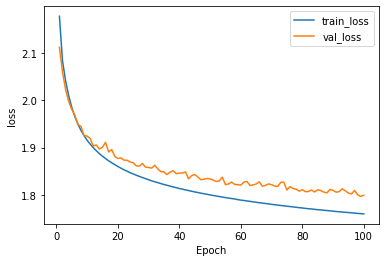

In [51]:
plt.plot(train_loss_values['Step'], train_loss_values['Value'], label='train_loss')
plt.plot(val_loss_values['Step'], val_loss_values['Value'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
# plt.show()
plt.savefig('imitation_tuned.jpg')

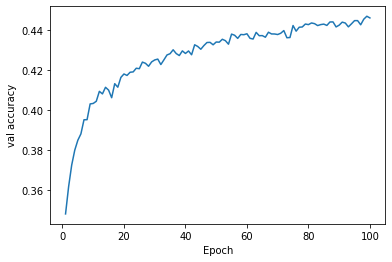

In [53]:
plt.plot(accuracies['Step'], accuracies['Value'])
plt.xlabel('Epoch')
plt.ylabel('val accuracy')
# plt.legend()
# plt.show()
plt.savefig('imitation_tuned_accuracy.jpg')